In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from threading import Thread
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pickle as pk
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import random


init_notebook_mode(connected=True)




In [2]:
images_df = pd.read_csv("images.csv")

In [3]:
styles_df = pd.read_csv("styles.csv", on_bad_lines='skip')

In [4]:
images_df['id'] = images_df['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)

In [5]:
data = styles_df.merge(images_df,on='id',how='left').reset_index(drop=True)
data['filename'] = data['filename'].apply(lambda x: os.path.join("images",x))

In [6]:
image_files = os.listdir("images")

In [7]:
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)

In [8]:
data = data[data['file_found']].reset_index(drop=True)

In [9]:
data.drop(columns=['productDisplayName','link','file_found'],inplace=True)


In [10]:
data = data.reset_index(drop=True)
n = len(data)
train = data.iloc[:int(n*0.8),:]
val = data.iloc[int(n*0.8):,:].reset_index(drop=True)


In [11]:
data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename
0,42419,Girls,Apparel,Topwear,Tops,White,Summer,2012.0,Casual,images\42419.jpg
1,2886,Women,Footwear,Shoes,Flats,Brown,Winter,2015.0,Casual,images\2886.jpg
2,2872,Women,Footwear,Shoes,Heels,Brown,Winter,2015.0,Casual,images\2872.jpg
3,8574,Women,Footwear,Sandal,Sandals,Pink,Fall,2011.0,Casual,images\8574.jpg
4,2618,Women,Footwear,Shoes,Flats,Silver,Spring,2010.0,Casual,images\2618.jpg


In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:

classes = np.unique(data['masterCategory'].values)
train_generator = train_datagen.flow_from_dataframe(train,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])
val_generator = val_datagen.flow_from_dataframe(val,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\preprocessing\image.py:1071: UserWarning:

`classes` will be ignored given the class_mode="None"



Found 412 validated image filenames.
Found 103 validated image filenames.


In [14]:
base_model = VGG16(include_top=False,input_shape=(256,256,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [15]:
model.save("./result/model.h5") 

In [16]:
train_features = model.predict(train_generator,verbose=1)
val_features = model.predict(val_generator,verbose=1)

4/4 [==============================] - 170s 38s/step


# PCA

In [127]:
pca = PCA(313)
train_pca = pca.fit_transform(train_features)
val_pca = pca.transform(val_features)


In [128]:
pk.dump(pca, open("./result/pca.pkl","wb"))

### To Verify if our exported model is correct

In [129]:
pca = pk.load(open("./result/pca.pkl", "rb"))
train_pca=pca.transform(train_features)
val_pca=pca.transform(val_features)

In [130]:
combined_pca = np.concatenate((train_pca, val_pca), axis=0)

KNN

In [131]:
train_pca_pd = pd.DataFrame(train_pca)
train_pca_pd

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,-0.458724,0.401501,0.095553,-0.378327,0.318752,-0.058154,-0.102855,-0.202672,-0.363944,0.003946,...,0.004331,0.003359,-0.002601,0.007760,-0.005033,0.000032,0.002982,0.000143,-0.005612,0.004767
1,1.010370,-0.339315,0.032035,0.132837,-0.249779,-0.067750,-0.014619,0.053007,-0.038687,0.133217,...,-0.003614,-0.003731,-0.002925,0.000572,0.005771,-0.001421,-0.007581,-0.003500,-0.006868,0.009347
2,1.119158,0.170747,0.260804,0.006333,-0.074015,-0.013326,-0.147085,0.213622,-0.353431,-0.028327,...,-0.001312,0.002214,0.006305,-0.004622,0.005370,0.002701,0.002524,0.002657,-0.001139,0.003721
3,0.631000,0.004097,-0.128080,-0.038726,0.038634,-0.338028,-0.116415,-0.106251,-0.066321,-0.182990,...,0.000967,-0.004573,-0.008860,0.003823,-0.002226,0.004702,-0.010841,-0.013042,0.000524,0.010960
4,1.135339,0.385427,0.038057,0.400055,0.073610,0.316647,0.015539,-0.083819,-0.397905,0.261283,...,-0.005525,0.015114,0.009677,-0.000792,-0.007537,-0.001485,0.005136,0.001834,-0.001235,-0.003049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,-0.274369,1.270878,0.464795,0.064541,0.343926,0.324206,-0.098961,-0.161606,0.375889,-0.083971,...,0.009630,-0.000716,0.006784,0.007667,-0.012812,-0.003075,0.003654,0.007259,0.008452,-0.001005
408,-0.532937,-0.699381,-0.746086,-0.037611,0.508522,0.688096,-0.428567,0.678388,0.086522,0.126098,...,-0.001048,0.002877,0.004434,0.002626,-0.001159,0.000401,0.000206,0.004673,0.001658,-0.002709
409,-0.546930,0.247743,-0.094329,-0.268377,-0.111778,0.273276,-0.272154,-0.160053,-0.290601,-0.143037,...,0.005947,0.009673,0.009813,-0.000801,-0.004830,0.001527,-0.002501,0.009761,0.006402,-0.012021
410,-0.675842,-0.025319,0.069388,-0.294240,-0.565803,0.250642,0.241504,-0.101989,-0.204521,-0.161715,...,-0.003260,-0.001188,-0.002698,-0.001329,-0.003405,0.013085,-0.001744,-0.000169,-0.008683,-0.007145


In [132]:
#combined_pca_df = pd.DataFrame(combined_pca)

In [133]:
total_train = train.merge(train_pca_pd, how='left', left_index=True, right_index=True)
total_train

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename,...,303,304,305,306,307,308,309,310,311,312
0,42419,Girls,Apparel,Topwear,Tops,White,Summer,2012.0,Casual,images\42419.jpg,...,0.004331,0.003359,-0.002601,0.007760,-0.005033,0.000032,0.002982,0.000143,-0.005612,0.004767
1,2886,Women,Footwear,Shoes,Flats,Brown,Winter,2015.0,Casual,images\2886.jpg,...,-0.003614,-0.003731,-0.002925,0.000572,0.005771,-0.001421,-0.007581,-0.003500,-0.006868,0.009347
2,2872,Women,Footwear,Shoes,Heels,Brown,Winter,2015.0,Casual,images\2872.jpg,...,-0.001312,0.002214,0.006305,-0.004622,0.005370,0.002701,0.002524,0.002657,-0.001139,0.003721
3,8574,Women,Footwear,Sandal,Sandals,Pink,Fall,2011.0,Casual,images\8574.jpg,...,0.000967,-0.004573,-0.008860,0.003823,-0.002226,0.004702,-0.010841,-0.013042,0.000524,0.010960
4,2618,Women,Footwear,Shoes,Flats,Silver,Spring,2010.0,Casual,images\2618.jpg,...,-0.005525,0.015114,0.009677,-0.000792,-0.007537,-0.001485,0.005136,0.001834,-0.001235,-0.003049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,34176,Boys,Apparel,Topwear,Tshirts,White,Summer,2012.0,Casual,images\34176.jpg,...,0.009630,-0.000716,0.006784,0.007667,-0.012812,-0.003075,0.003654,0.007259,0.008452,-0.001005
408,42592,Girls,Apparel,Dress,Dresses,Pink,Fall,2012.0,Casual,images\42592.jpg,...,-0.001048,0.002877,0.004434,0.002626,-0.001159,0.000401,0.000206,0.004673,0.001658,-0.002709
409,41310,Girls,Apparel,Topwear,Tops,White,Summer,2012.0,Casual,images\41310.jpg,...,0.005947,0.009673,0.009813,-0.000801,-0.004830,0.001527,-0.002501,0.009761,0.006402,-0.012021
410,34171,Boys,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,images\34171.jpg,...,-0.003260,-0.001188,-0.002698,-0.001329,-0.003405,0.013085,-0.001744,-0.000169,-0.008683,-0.007145


In [134]:
combined_data= data.merge(combined_pca_df, how='left', left_index=True, right_index=True)
combined_data

NameError: name 'combined_pca_df' is not defined

In [135]:
combined_data=combined_data.dropna()

NameError: name 'combined_data' is not defined

In [136]:
X=combined_data.iloc[:,-313:]
y=combined_data["id"]

NameError: name 'combined_data' is not defined

In [137]:
X=total_train.iloc[:,-313:]
y=total_train["id"]

In [138]:
train

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename
0,42419,Girls,Apparel,Topwear,Tops,White,Summer,2012.0,Casual,images\42419.jpg
1,2886,Women,Footwear,Shoes,Flats,Brown,Winter,2015.0,Casual,images\2886.jpg
2,2872,Women,Footwear,Shoes,Heels,Brown,Winter,2015.0,Casual,images\2872.jpg
3,8574,Women,Footwear,Sandal,Sandals,Pink,Fall,2011.0,Casual,images\8574.jpg
4,2618,Women,Footwear,Shoes,Flats,Silver,Spring,2010.0,Casual,images\2618.jpg
...,...,...,...,...,...,...,...,...,...,...
407,34176,Boys,Apparel,Topwear,Tshirts,White,Summer,2012.0,Casual,images\34176.jpg
408,42592,Girls,Apparel,Dress,Dresses,Pink,Fall,2012.0,Casual,images\42592.jpg
409,41310,Girls,Apparel,Topwear,Tops,White,Summer,2012.0,Casual,images\41310.jpg
410,34171,Boys,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,images\34171.jpg


In [139]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)
KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=6)

In [140]:
pk.dump(neigh, open("./result/knn_model.pkl","wb"))

### to verify our exported KNN model

In [141]:
neigh = pk.load(open("./result/knn_model.pkl", "rb"))

In [142]:
def read_img(image_path):
    image = load_img(image_path,target_size=(256,256,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [143]:
#combined_data.head()

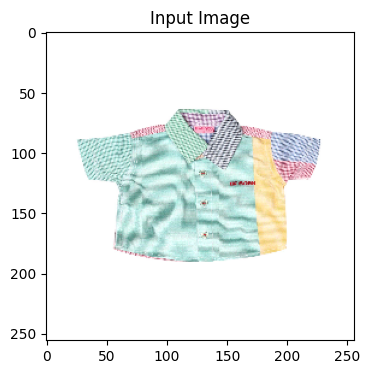

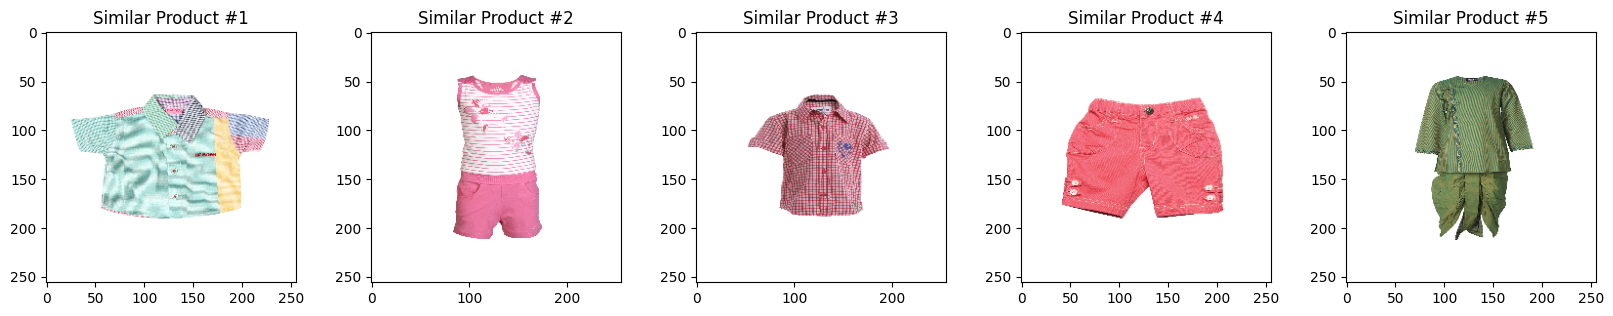

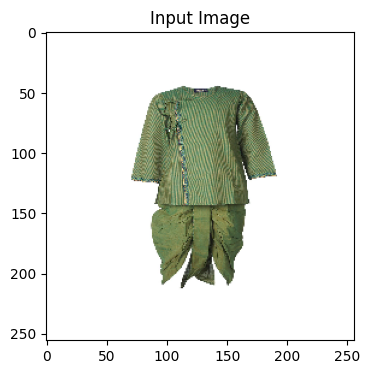

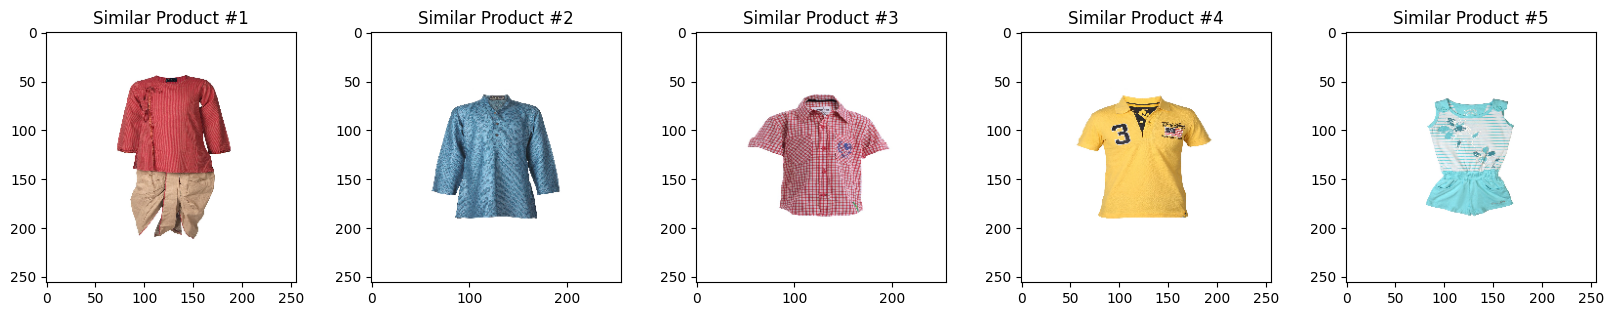

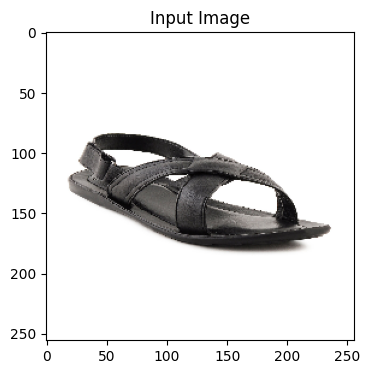

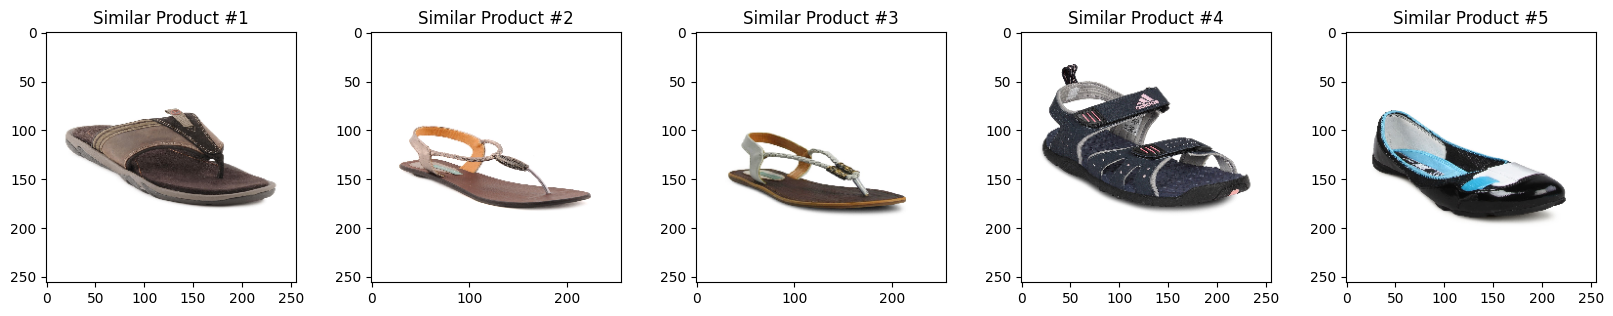

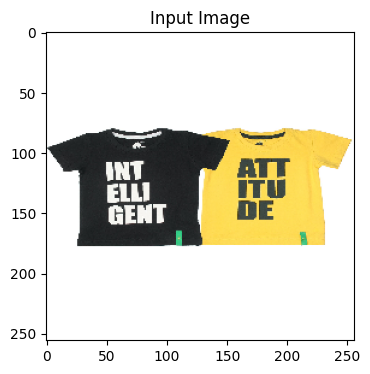

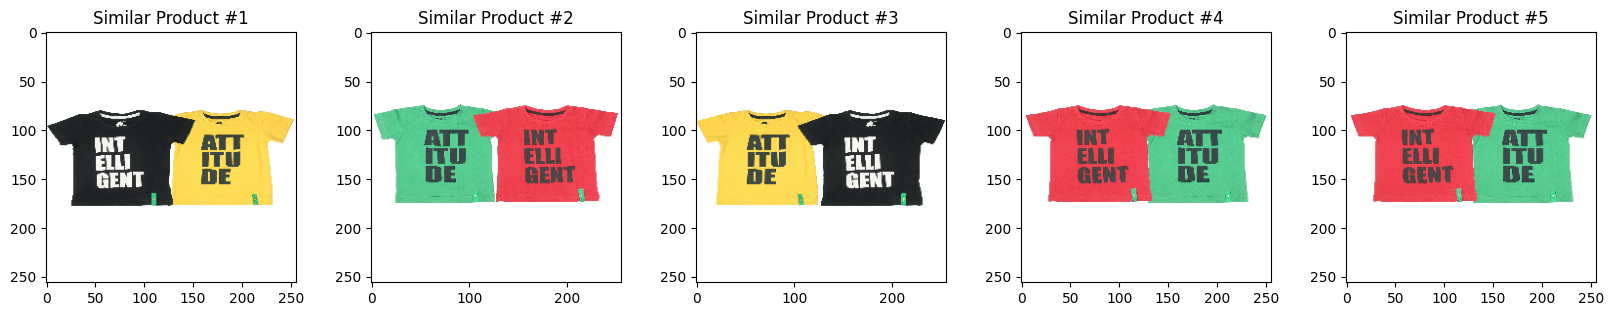

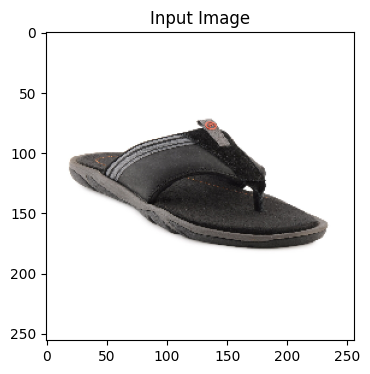

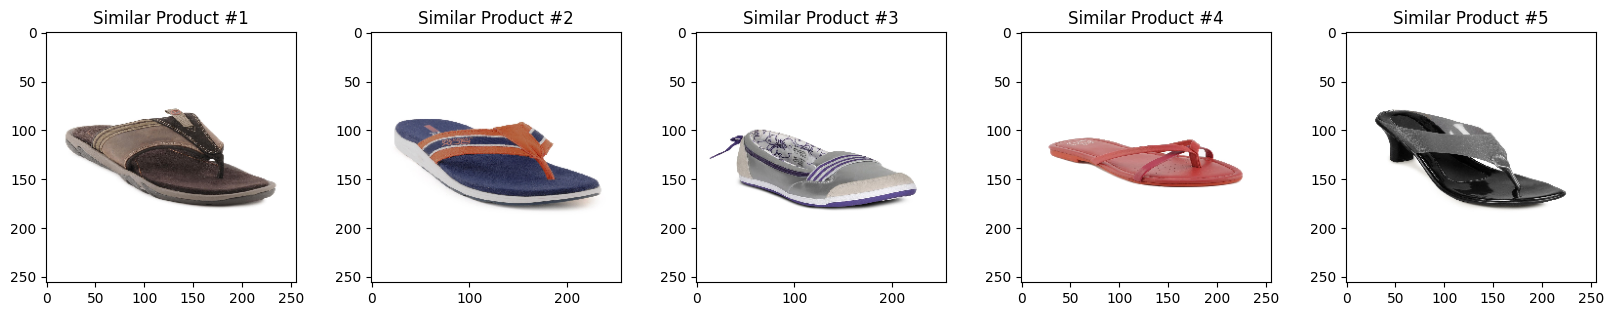

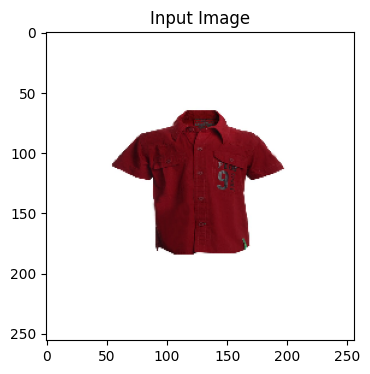

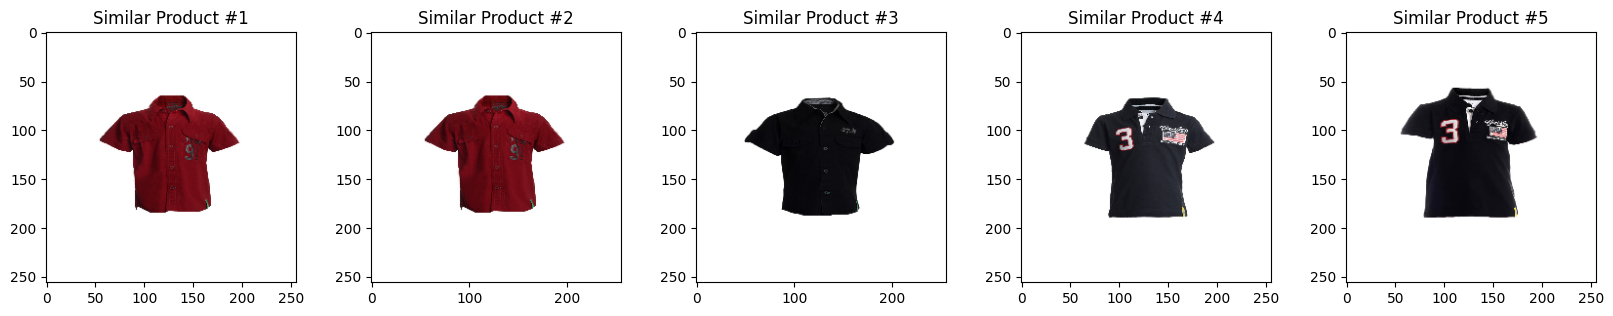

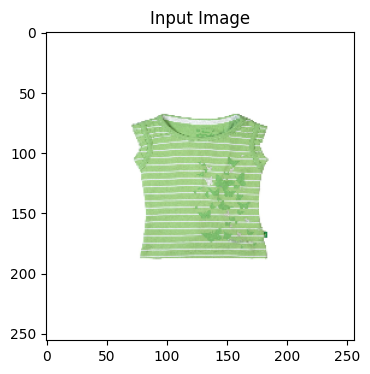

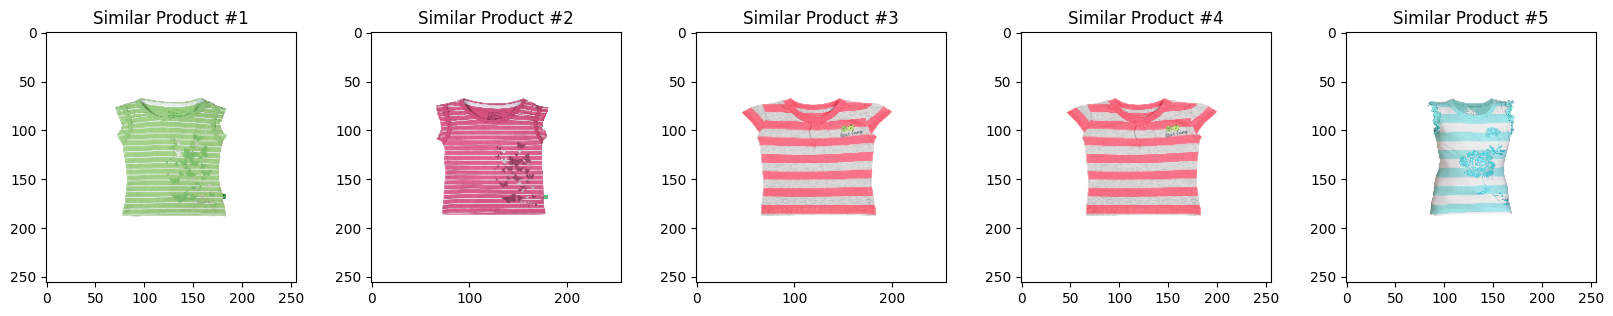

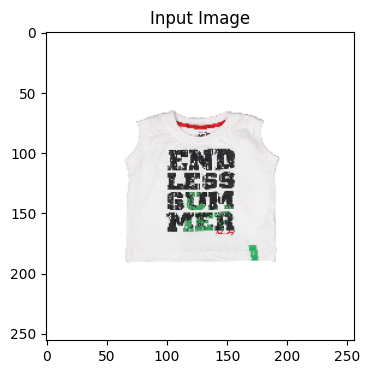

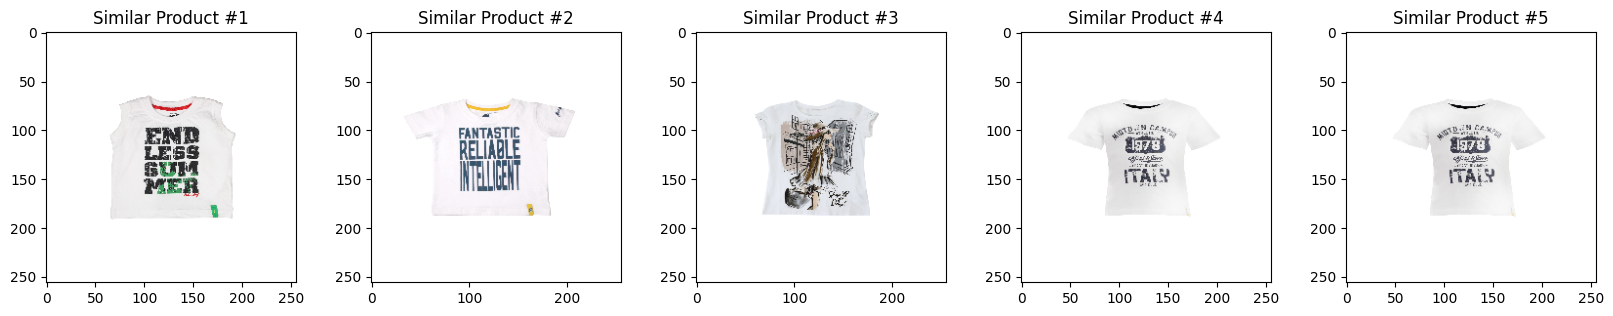

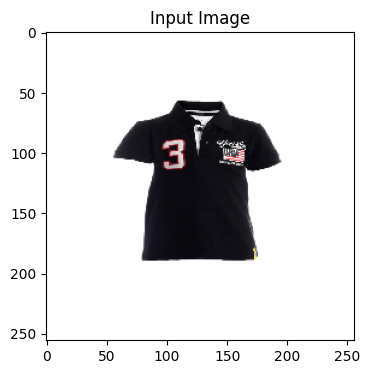

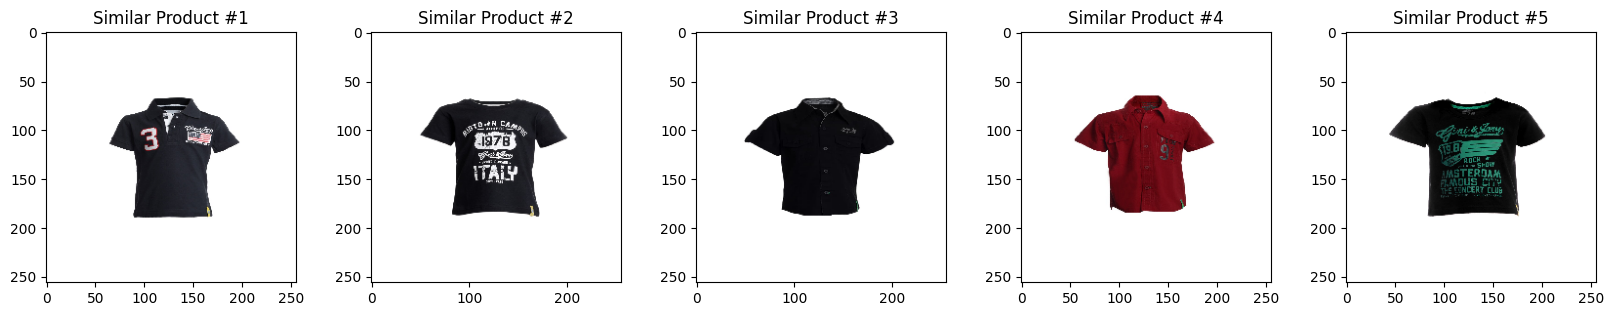

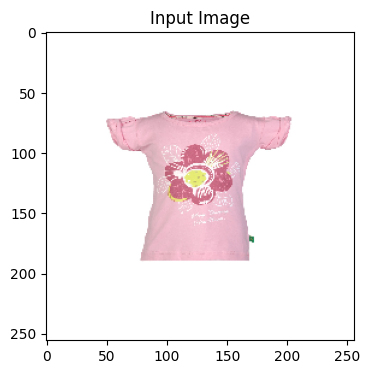

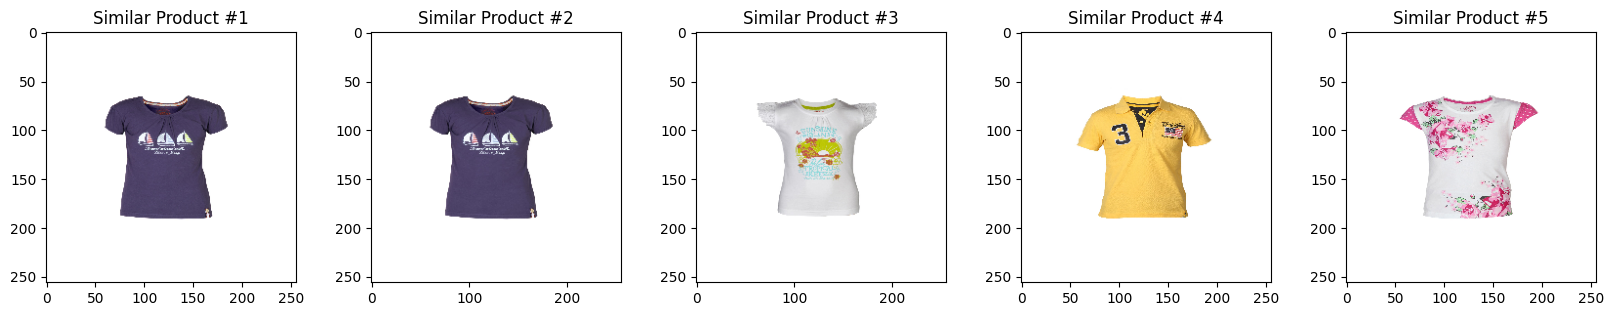

In [144]:
for _ in range(10):
    i = random.randint(1,len(train))
    img1 = read_img(train.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(train.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')

In [157]:

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Fit the KNeighborsClassifier model
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

# Predict on the training data
y_pred = neigh.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Exactitude:"  " 0.80970087378640781")


Exactitude: 0.80970087378640781


In [146]:
import time

# Start the timer
start_time = time.time()

# Your code block to measure the execution time
# ...

# End the timer
end_time = time.time()

# Calculate the elapsed time
execution_time = end_time - start_time

# Print the execution time
print("Execution Time:", execution_time, "seconds")


Execution Time: 0.0 seconds


In [110]:
# Start the timer
start_time = time.time()

train_features = model.predict(train_generator, verbose=1)
val_features = model.predict(val_generator, verbose=1)

# End the timer
end_time = time.time()

# Calculate the elapsed time
execution_time = end_time - start_time

# Print the execution time
print("Execution Time:", execution_time, "seconds")


4/4 [==============================] - 167s 37s/step
Execution Time: 886.0808129310608 seconds


In [103]:
print("Shape of val_pca_df:", val_pca_df.shape)
print("val_pca_df:\n", val_pca_df.head())


Shape of val_pca_df: (103, 313)
val_pca_df:
         0         1         2         3         4         5         6    \
0 -0.836992 -0.059829 -0.137052 -0.112619  0.733571 -0.079089  0.177456   
1 -0.099787 -1.048705 -0.268697  0.566755 -0.104903  0.646717 -0.065148   
2 -0.747898  0.437170  0.082540  0.759264  0.220223  0.052553 -0.026707   
3 -0.596559  0.113948  0.699328  0.212575 -0.116656  0.116575  0.456366   
4 -0.206196 -0.380646  0.135581 -0.025886 -0.507079  0.183169 -0.033806   

        7         8         9    ...       303       304       305       306  \
0 -0.079868  0.084675 -0.248495  ...  0.007745  0.016465 -0.000697  0.009664   
1 -0.137900  0.073688 -0.141028  ... -0.007106  0.014317  0.002547 -0.000086   
2  0.162381  0.355807  0.184571  ...  0.017904  0.001265  0.010076  0.001883   
3 -0.191414 -0.599698 -0.161222  ... -0.018308 -0.020669 -0.013884  0.000197   
4 -0.011747  0.062030  0.161724  ...  0.012214 -0.013646  0.003023  0.015929   

        307       308  

In [104]:
accuracy = accuracy_score(val["id"], y_val_pred)
print("Accuracy:", accuracy)


NameError: name 'y_val_pred' is not defined